In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -Uqq duckduckgo_search
!pip install fastbook
!pip install nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 21.5 MB/s eta 0:00:00
  Obtaining dependency information for nbdev from https://files.pythonhosted.org/packages/45/44/2148be2391edd62b8c88c2114f380141b72276901a53d590be9f769a68e4/nbdev-2.3.13-py3-none-any.whl.metadata
  Obtaining dependency information for ghapi>=1.0.3 from https://files.pythonhosted.org/packages/60/71/064560201c434c22c9f395878ba0f21f9ede8169e61c1a109f26a377bd5e/ghapi-1.0.4-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 7.3 MB/s eta 0:00:00


In [3]:
#|export
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from fastbook import *
from fastai.vision.widgets import *

In [4]:
def search_images(term, max=30):
  print(f"Searching for '{term}'")
  # search_images_ddg comes from fastbook: https://github.com/fastai/fastbook/blob/master/utils.py#L45
  return search_images_ddg(term, max_images=max)

## Search single meme

Searching for 'this is fine meme'


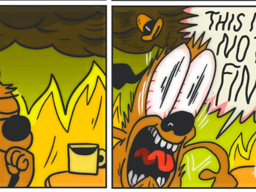

In [5]:
urls = search_images("this is fine meme", max=1)
dest = 'this is fine meme.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'salt bae meme'


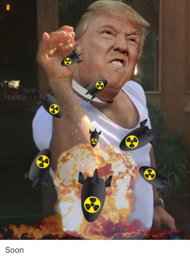

In [6]:
urls = search_images("salt bae meme", max=1)
dest = 'salt bae meme.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

## Batch download

In [7]:
#|export
searches = "salt bae","this is fine"
path = Path('which_meme_is_this')
from time import sleep

for item in searches:
    dest = (path/item)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{item} meme'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{item} photo'))
    sleep(10)
    resize_images(path/item, max_size=400, dest=path/item) # 400 here splits into 200 for each item

Searching for 'salt bae meme'
Searching for 'salt bae photo'
Searching for 'this is fine meme'
Searching for 'this is fine photo'


In [8]:
fns = get_image_files(path)
fns

(#118) [Path('which_meme_is_this/this is fine/9f10f530-694e-4a52-8560-c9f61f9c2764.gif'),Path('which_meme_is_this/this is fine/2ed46f73-210c-403d-b262-2ac7de3a8cff.jpg'),Path('which_meme_is_this/this is fine/d454e908-47f0-4be2-bcd8-7efe01cc760e.jpg'),Path('which_meme_is_this/this is fine/8303eca7-8601-4e5f-9a63-f83d055859b2.jpg'),Path('which_meme_is_this/this is fine/02125572-af9c-4b55-ba65-ea911e0767d8.png'),Path('which_meme_is_this/this is fine/bb9a04ca-6a61-4cc4-a6ac-94d03dfe690d.jpg'),Path('which_meme_is_this/this is fine/554b78ea-e12f-452c-856d-b50853e146b0.png'),Path('which_meme_is_this/this is fine/12387e91-6164-4ff6-9739-fbc4c0b8f0c0.png'),Path('which_meme_is_this/this is fine/12f68b33-bf71-4c5f-a0d5-c7252cefb3d9.gif'),Path('which_meme_is_this/this is fine/e9abaff9-ba75-4d34-bc3c-35c0561be74a.png')...]

In [9]:
#|export
failed = verify_images(fns)

In [10]:
#|export
failed.map(Path.unlink) # remove failed links

(#10) [None,None,None,None,None,None,None,None,None,None]

In [11]:
#|export
memes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # inputs to our model are images, and the outputs are categories
    get_items=get_image_files, # find all the inputs to our model, which returns a list of all image files in a path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Split the data into training and validation sets randomly, using 20% of the data for the validation set.
    get_y=parent_label, # the labels will be the parent of each file, in this case the folder they are in, new york, or mushroom
    item_tfms=[Resize(192, method='squish')] #resize each image to 192x192 pixels by "squishing" it
)
dls = memes.dataloaders(path)

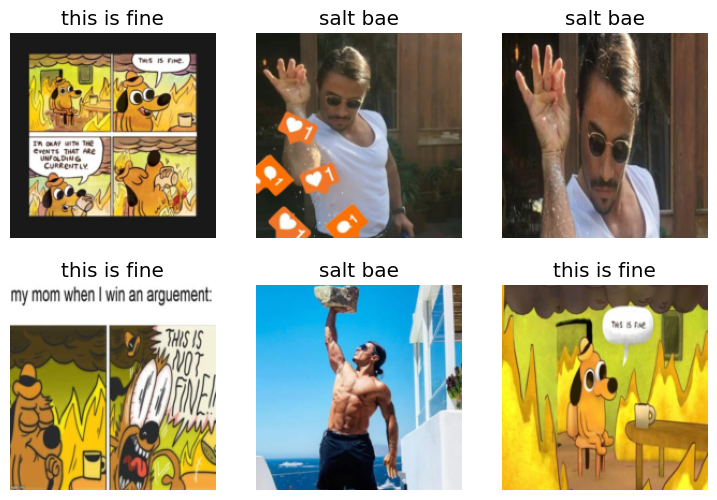

In [12]:
dls.show_batch(max_n=6)

## Data augamentation

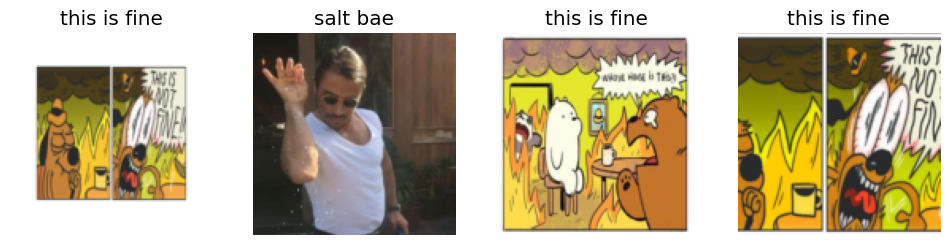

In [13]:
# To squish the images
memes = memes.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = memes.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

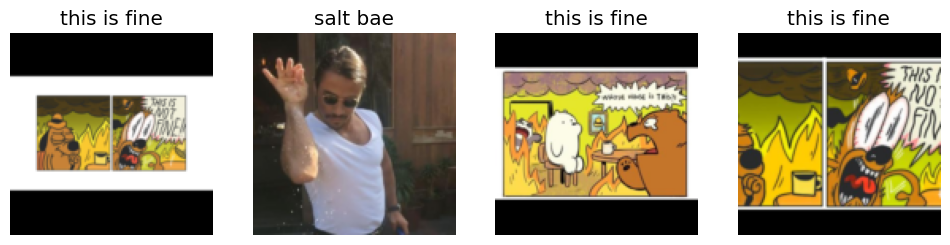

In [14]:
# To add pads to the images
memes = memes.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = memes.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

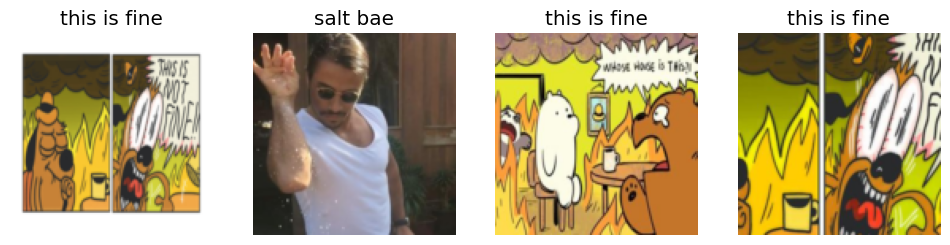

In [15]:
# To add random crop
memes = memes.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = memes.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

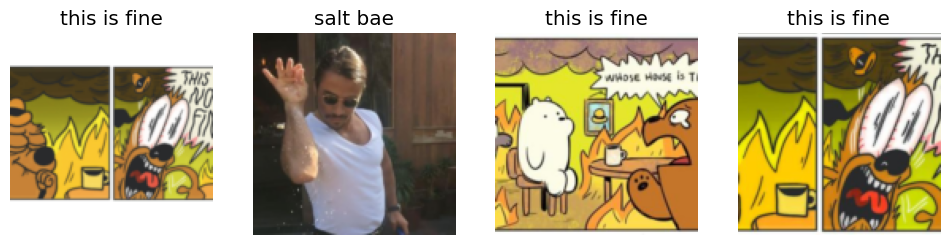

In [16]:
memes = memes.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = memes.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

## Training the Model, and Using It to Clean Data

In [17]:
#|export
memes = memes.new(
    item_tfms=Resize(128, ResizeMethod.Squish),
    batch_tfms=aug_transforms())
dls = memes.dataloaders(path)

In [18]:
#|export
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 270MB/s]


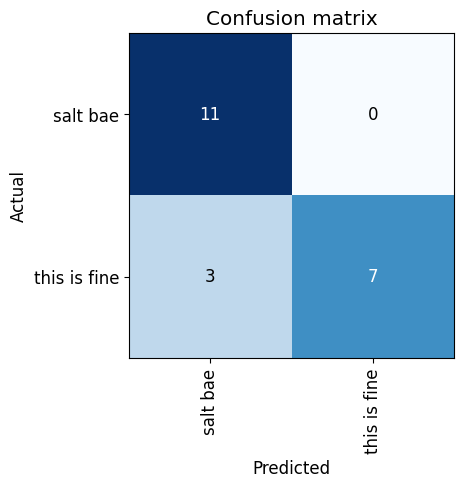

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

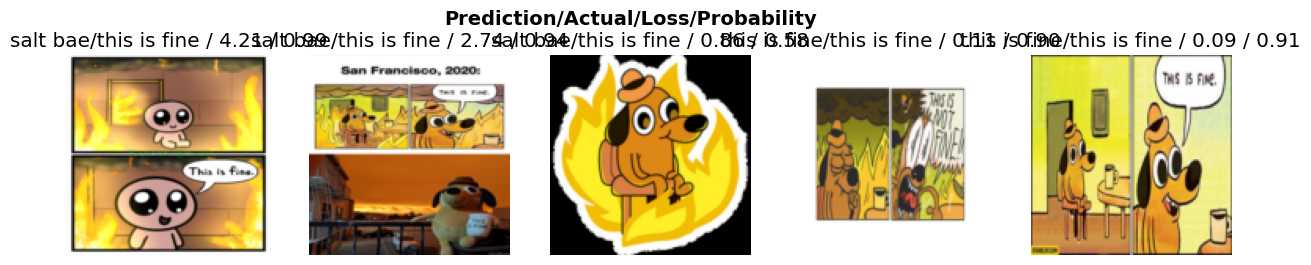

In [20]:
interp.plot_top_losses(5, nrows=1)

In [21]:
cleaner = ImageClassifierCleaner(learn)
cleaner

## Export the model

In [22]:
#|export
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [23]:
learn_inf = load_learner(path/'export.pkl')

## “This is fine” or "Salt bae"

In [24]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [25]:
# Uncomment to run prediction
# img = PILImage.create(btn_upload.data[-1])
# out_pl = widgets.Output()
# out_pl.clear_output()
# with out_pl: display(img.to_thumb(128,128))
# out_pl

In [26]:
# Uncomment to run prediction
# pred,pred_idx,probs = learn_inf.predict(img)
# lbl_pred = widgets.Label()
# lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
# lbl_pred